<a href="https://colab.research.google.com/github/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/d2602fefa8540ad79bd793247f67058e6c129701/projects/05-1PLXXXX_political_color_posts/results/project_report_lukas_pasold.ipynb
" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probabilistic Machine Learning - Project Report

**Course:** Probabilistic Machine Learning (Summer Term 2025) \
**Lecturer:** Alvaro Diaz-Ruelas \
**Student Name:** Lukas Pasold \
**GitHub Username:** lukasp0910 \
**Date:** 29.07.2025   
**PROJECT-ID:** 05-1PL

## 1. Introduction

In recent national and international elections, social media has proven to be one of the most important instruments of political communication. Platforms like Instagram allow political parties to reach voters directly and shape their public image through carefully curated visual content.

This project explores whether Instagram posts from German political parties can be classified based on their dominant colors. To do this, a dataset of all publicly available Instagram posts from the major German parties was collected, dating back to the creation of each respective account, resulting in a total of approximately 28,500 posts. From each image, the four most dominant colors were extracted and used as compact feature vectors to train a range of classifiers.

The study aims to answer the following questions:

- How well can simple visual features, such as dominant colors, distinguish between political parties?
- How do different feature representations and preprocessing strategies affect classification performance?
- And how do probabilistic methods such as Gaussian Mixture Models and Linear Discriminant Analysis compare to non-probabilistic approaches in terms of classification accuracy and robustness?

To address these questions, the study systematically evaluates various color spaces, clustering algorithms, and classification methods. It also examines the impact of incorporating temporal information and applying selective data filtering strategies to enhance model accuracy.


## 2. Data Loading and Exploration

The dataset used in this project consists of all publicly available Instagram posts from the seven major political parties in Germany: **CDU**, **CSU**, **SPD**, **FDP**, **Bündnis 90/Die Grünen**, **Die Linke**, and **AfD**. The data spans from the creation of the respective Instagram accounts, whose first posts were published between 2014 and 2019, up to December 18, 2024 and includes 28,423 posts in total. The posts were collected using a custom Python script ([`instagramdownload.py`](https://github.com/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/f844059ac029ad1ad1d9f53fd755647ed5a29dd5/projects/05-1PLXXXX_political_color_posts/notebooks/instagramdownload.py)), which systematically downloaded image content and metadata from the official Instagram accounts of each party.

Due to data constraints, the full image dataset is not uploaded alongside this report. However, all images and metadata used in the analysis remain publicly accessible via the parties' official Instagram pages:


*   [CDU](https://www.instagram.com/cdu/)
*   [CSU](https://www.instagram.com/csu/)
*   [SPD](https://www.instagram.com/spd_de/)
*   [FDP](https://www.instagram.com/fdp/)
*   [Bündnis 90/Die Grünen](https://www.instagram.com/die_gruenen/)
*   [Die Linke](https://www.instagram.com/dielinke/)
*   [Afd](https://www.instagram.com/afd.bund/)

After downloading, the data was organized into a local database containing each post's image path, publication date, and party affiliation. A first overview of the dataset is given below, showing the number of posts per party:

| Party     | Number of Posts |
|-----------|-----------------|
| CDU       | 5687            |
| CSU       | 6776            |
| SPD       | 2816            |
| FDP       | 4206            |
| Grüne     | 2658            |
| Linke     | 4225            |
| AfD       | 2055            |
| **Total** | **28,423**      |

In addition, the monthly posting frequency per party was visualized across the full time span of the dataset. The resulting plot highlights general trends, variations in engagement levels, and increased activity during election periods.

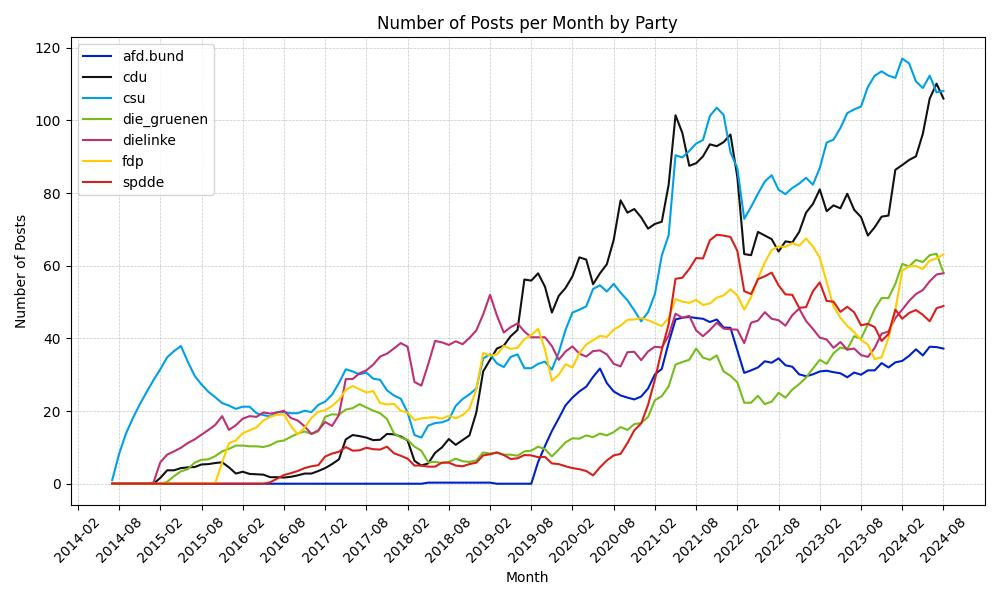

There is no missing data in the final dataset. Each post is associated with a valid timestamp, a party label, and a corresponding image. While some older posts may vary in resolution, this does not affect the feature extraction process based on color clustering.

## 3. Data Preprocessing

To prepare the dataset for machine learning, the first step was to transform the raw Instagram image data into compact and informative feature representations. For this purpose, a preprocessing pipeline was developed to extract the dominant colors from each image using clustering techniques. K-Means clustering was applied to both RGB and HSV color spaces using the scripts [`rgb_extract_colors.py`](https://github.com/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/f844059ac029ad1ad1d9f53fd755647ed5a29dd5/projects/05-1PLXXXX_political_color_posts/notebooks/rgb_extract_colors.py) and [`hsv_extract_colors.py`](https://github.com/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/f844059ac029ad1ad1d9f53fd755647ed5a29dd5/projects/05-1PLXXXX_political_color_posts/notebooks/hsv_extract_colors.py), respectively. In addition, a Gaussian Mixture Model (GMM) was used to extract dominant colors in RGB space, with a dedicated script [`extract_colors_rgb_gmm.py`](https://github.com/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/f844059ac029ad1ad1d9f53fd755647ed5a29dd5/projects/05-1PLXXXX_political_color_posts/notebooks/extract_colors_rgb_gmm.py) for applying GMM in HSV space.

The code snippet below illustrates the color extraction process using RGB with K-Means as an example:
```
def extract_rgb_palette(image_path, num_colors):
    """Extracts color palette and returns feature vector."""
    img = Image.open(image_path).convert('RGB')
    img = img.resize((img.width // 2, img.height // 2))
    img_array = np.array(img)

    img_rgb = img_array.reshape((-1, 3))

    kmeans = KMeans(n_clusters=num_colors, random_state=0)
    kmeans.fit(img_rgb)
    colors_rgb = kmeans.cluster_centers_
    colors_rgb = np.round(colors_rgb).astype(int)

    return colors_rgb
```

Each row in these CSV files represents a single image, and the extracted colors are stored as a set of numerical features. More precisely, each feature vector consists of 12 values: one for each channel (R, G, B or H, S, V) of the four dominant colors identified by the clustering algorithm.

As a next step, an additional feature was added to both the RGB and HSV CSV files: the upload time of each Instagram post, stored in Unix time format. This was implemented using the script [`add_timestamp_feature.py`](https://github.com/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/f844059ac029ad1ad1d9f53fd755647ed5a29dd5/projects/05-1PLXXXX_political_color_posts/notebooks/add_timestamp_feature.py). The motivation behind including temporal information was that several parties have significantly changed their corporate color schemes over the years. By incorporating the upload time, the study aimed to help the classifiers adjust to these temporal shifts in visual branding and potentially improve overall classification performance.

As a final preprocessing step, a key challenge with the dataset was adressed. Many posts do not prominently feature the party’s corporate colors, which makes color-based classification difficult and reduces overall performance. To counter this, a Random Forest Classifier was trained on the entire dataset and cross-validation was used to estimate prediction confidence for each post. This was implemented in the notebook [`color_relevance_estimation.ipynb`](https://colab.research.google.com/github/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/f844059ac029ad1ad1d9f53fd755647ed5a29dd5/projects/05-1PLXXXX_political_color_posts/notebooks/color_relevance_estimation.ipynb). Based on the results, two new columns were added to both the RGB and HSV CSV files. The first column, confidence, contains the predicted probability for the assigned class. The second column, relevant, is a binary indicator set to 1 whenever the confidence exceeds a threshold of 0.4. This enables filtering the dataset for posts with strong color signals, which are more likely to reflect the parties' visual identity. The distribution of confidence scores across all posts is illustrated in the two plots below, one for each color space.

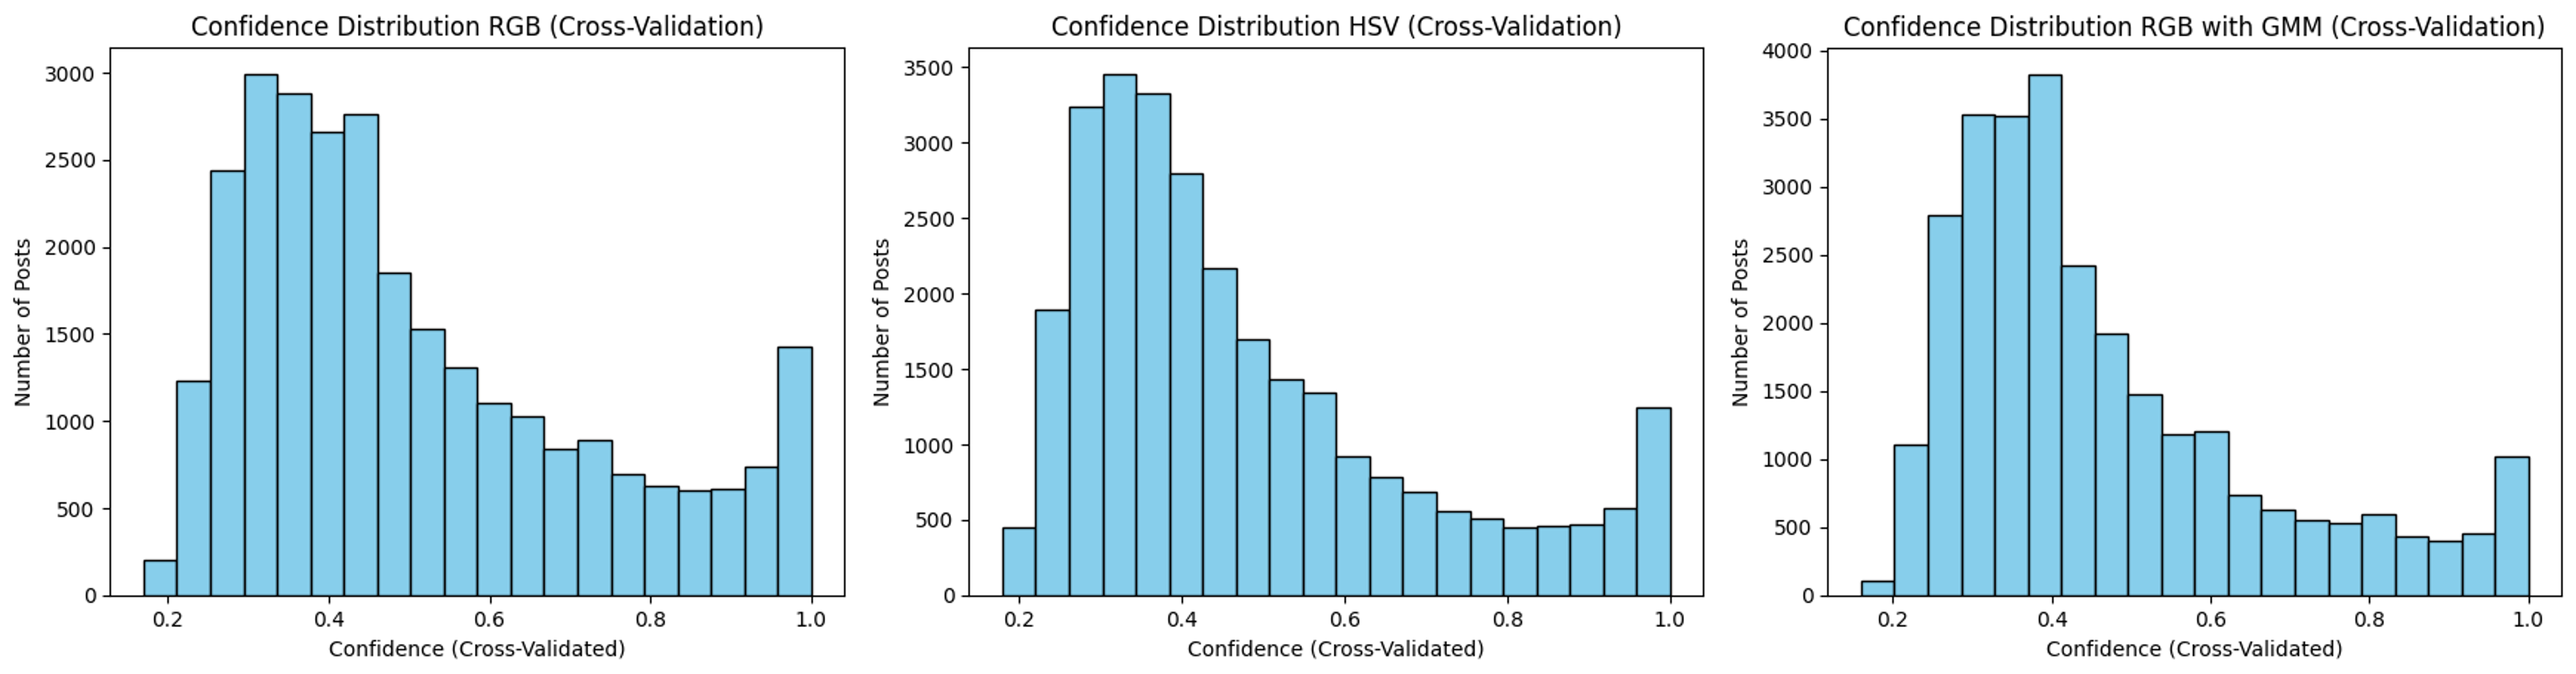

The final preprocessed feature datasets, incorporating both the extracted color palette features and the additional metadata columns are stored in the files [`final-features-rgb.csv`](https://github.com/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/f844059ac029ad1ad1d9f53fd755647ed5a29dd5/projects/05-1PLXXXX_political_color_posts/data/final-features-rgb.csv), [`final-features-hsv.csv`](https://github.com/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/f844059ac029ad1ad1d9f53fd755647ed5a29dd5/projects/05-1PLXXXX_political_color_posts/data/final-features-hsv.csv) and [`final-features-rgb-gmm.csv`](https://github.com/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/f844059ac029ad1ad1d9f53fd755647ed5a29dd5/projects/05-1PLXXXX_political_color_posts/data/final-features-rgb-gmm.csv). Below is a preview of some rows of the RGB (k-means) feature table:

| party | filename                        | feature_0 | feature_1 | feature_2 | feature_3 | feature_4 | feature_5 | feature_6 | feature_7 | feature_8 | feature_9 | feature_10 | feature_11 | date       | feature_12 | confidence | relevant |
|--------|--------------------------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-------------|-------------|------------|-------------|-------------|----------|
| spd    | 2024-04-16_09-03-47_UTC.jpg    | 90        | 49        | 50        | 207       | 195       | 180       | 227       | 96        | 56        | 21        | 11          | 10          | 2024-04-16 | 1713225600  | 0.24        | 0        |
| spd    | 2024-04-18_11-19-41_UTC.jpg    | 41        | 37        | 31        | 216       | 16        | 22        | 251       | 242       | 238       | 213       | 148         | 127         | 2024-04-18 | 1713398400  | 0.41        | 1        |
| spd    | 2024-04-21_08-03-51_UTC.jpg    | 23        | 17        | 16        | 249       | 238       | 235       | 225       | 2         | 14        | 192       | 137         | 115         | 2024-04-21 | 1713657600  | 0.82        | 1        |
| spd    | 2024-04-22_14-32-27_UTC.jpg    | 252       | 247       | 247       | 226       | 2         | 16        | 20        | 47        | 109       | 235       | 172         | 52          | 2024-04-22 | 1713744000  | 0.49        | 1        |
| spd    | 2024-04-23_08-21-30_UTC.jpg    | 12        | 12        | 13        | 161       | 130       | 120       | 247       | 244       | 243       | 84        | 62          | 55          | 2024-04-23 | 1713830400  | 0.29        | 0        |

## 4. Probabilistic Modeling Approach

To test the classification performance of the images, various probabilistic and non-probabilistic approaches were used for color clustering and classification. Specifically, **K-Means** and **Gaussian Mixture Models (GMM)** were applied for clustering the color data, while classification was performed using **Linear Discriminant Analysis (LDA)** as a probabilistic method, and **Random Forest**, **XGBoost**, **Support Vector Machine (SVM)**, and **Multilayer Perceptron (MLP)** as a non-probabilistic baseline.

K-Means is a non-probabilistic algorithm that performs hard clustering by assigning each point to the nearest cluster center, assuming spherical and equally sized clusters. [[8]](#ref-macqueen1967) In contrast, Gaussian Mixture Models (GMM) use a probabilistic approach, allowing soft assignments where each point has a probability of belonging to multiple clusters. GMM can model more flexible, elliptical cluster shapes. [[9]](#ref-dempster1977)

Random Forest follows an ensemble-based strategy by combining the outputs of many decision trees. Each tree is trained on a different subset of the data and features, introducing diversity into the model. When predicting the class of a new input, each tree casts a “vote” for one of the possible parties, and the class with the majority of votes is chosen as the final output. Additionally, because each tree can output class probabilities, the average over all trees gives a measure of predictive confidence. This ensemble approach is particularly robust to noise and overfitting, making it a reliable choice when dealing with real-world image data. [[1]](#ref-breiman2001)[[5]](#ref-rodriguez2012)

XGBoost, short for extreme Gradient Boosting, is another ensemble learning method that builds upon the concept of decision trees. Unlike Random Forest, which uses a bagging approach (training trees independently), XGBoost employs a boosting strategy. It sequentially builds trees, where each new tree aims to correct the errors made by the previously trained trees. This iterative refinement process allows XGBoost to progressively focus on misclassified instances, leading to a highly accurate and robust model. Furthermore, XGBoost incorporates regularization techniques to prevent overfitting, making it efficient and scalable, especially when dealing with large datasets and complex feature interactions. This makes it a strong contender for tasks requiring high predictive power and computational efficiency. [[7]](#ref-chen2016)

The SVM model, on the other hand, is based on geometric principles. It seeks to find the optimal hyperplane that best separates the different classes in the feature space. The main objective is to maximize the margin between the closest data points from different classes, ensuring a decision boundary that generalizes well to unseen data. Even if the classes cannot be separated in the original space, the SVM can transform the data into a higher-dimensional space where separation becomes possible. This makes SVM especially well-suited for cases where class boundaries are subtle, as it focuses on the most informative data points near the class borders. [[2]](#ref-cortes1995)[[4]](#ref-hsu2016)

The MLP Classifier introduces a fundamentally different, neural-network-based approach. It consists of several layers of interconnected units that learn hierarchical representations of the input features. Each layer applies non-linear transformations, allowing the model to capture complex interactions and non-obvious patterns in the data. The training process adjusts the connection weights to minimize classification error across all examples. This makes MLPs particularly powerful in settings where the relation between features and classes is non-linear and cannot be easily described by simple geometric boundaries. [[3]](#ref-goodfellow2016)[[6]](#ref-rumelhart1986)

Linear Discriminant Analysis (LDA) is a supervised learning method that models the probability of class membership using Bayes' theorem, assuming normally distributed data with class-specific means but shared covariance. It projects high-dimensional data onto a lower-dimensional space to maximize class separability. [[10]](#ref-fisher1936)

## 5. Model Training and Evaluation

To train and evaluate the classification models, different combinations of input features and data subsets were systematically explored across both color spaces, RGB and HSV. For each color space, the classifiers Random Forest, XGBoost, SVM, MLP, and LDA were applied using three different setups. In the first setup, the models were trained using only the twelve color features extracted from the image palettes. In the second setup, the upload time was included as an additional feature. In the final setup, only those posts marked as relevant based on their classification confidence were used. This configuration was designed to assess how the inclusion of temporal information and the exclusion of visually ambiguous images affect the performance of the classifiers.

During data preparation, the feature matrix was separated from the target labels in order to enable model training.

```
# For Setup 1
  X = df[[f'feature_{i}' for i in range(12)]]
  y = df['party']

# For Setup 2
  X = df[[f'feature_{i}' for i in range(13)]]
  y = df['party']

# For Setup 3
  X = df[[f'feature_{i}' for i in range(13)]]
  y = df['party']
  relevant = df['relevant']
  mask = (relevant == 1)
  X = X[mask]
  y = y[mask]
```

Next, the dataset was split into training and test portions. This split was performed in a way that maintains the distribution of classes across both sets, ensuring that each class is represented proportionally.

```
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
```

Once the data was prepared, the classifiers were trained on the training set and evaluated on the test set. Each model was fitted and tested separately for all combinations of cluster algorithms, color spaces and feature sets. The specific configurations for all classifiers are shown below.

```
# 1. Random Forest
  rf = RandomForestClassifier(class_weight='balanced', random_state=42)
  rf.fit(X_train, y_train)
  y_pred_rf = rf.predict(X_test)
  report_rf = classification_report(y_test, y_pred_rf)

# 2. XGBoost
  # Encode the target variable
  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  y_train_encoded = le.fit_transform(y_train)
  y_test_encoded = le.transform(y_test)

  xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
  xgb.fit(X_train, y_train_encoded)
  y_pred_xgb_encoded = xgb.predict(X_test)

  # Decode the predictions back to original labels for classification report
  y_pred_xgb = le.inverse_transform(y_pred_xgb_encoded)

  report_xgb = classification_report(y_test, y_pred_xgb)

# 3. Support Vector Machine (SVM)
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  svm = SVC(kernel='rbf', class_weight='balanced', random_state=42)
  svm.fit(X_train_scaled, y_train)
  y_pred_svm = svm.predict(X_test_scaled)
  report_svm = classification_report(y_test, y_pred_svm)

# 4. MLP Classifier
  mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    learning_rate_init=0.001,
    max_iter=1000,
    alpha=0.0001,
    random_state=42
  )
  mlp.fit(X_train_scaled, y_train)
  y_pred_mlp = mlp.predict(X_test_scaled)
  report_mlp = classification_report(y_test, y_pred_mlp)

# 5. Linear Discriminant Analysis (LDA)
  lda = LinearDiscriminantAnalysis()
  lda.fit(X_train_scaled, y_train)
  y_pred_lda = lda.predict(X_test_scaled)
  report_lda = classification_report(y_test, y_pred_lda)

```

To evaluate model performance, the F1-score was used as the primary metric, as it provides a balanced measure of precision and recall and is well-suited to multi-class classification tasks with uneven class distributions. After completing all training and evaluation runs, a table of the resulting F1-scores was compiled for each configuration. This final overview offers a comparative perspective on how each model and feature setup performed, highlighting the impact of time-based features and confidence filtering on classification accuracy.

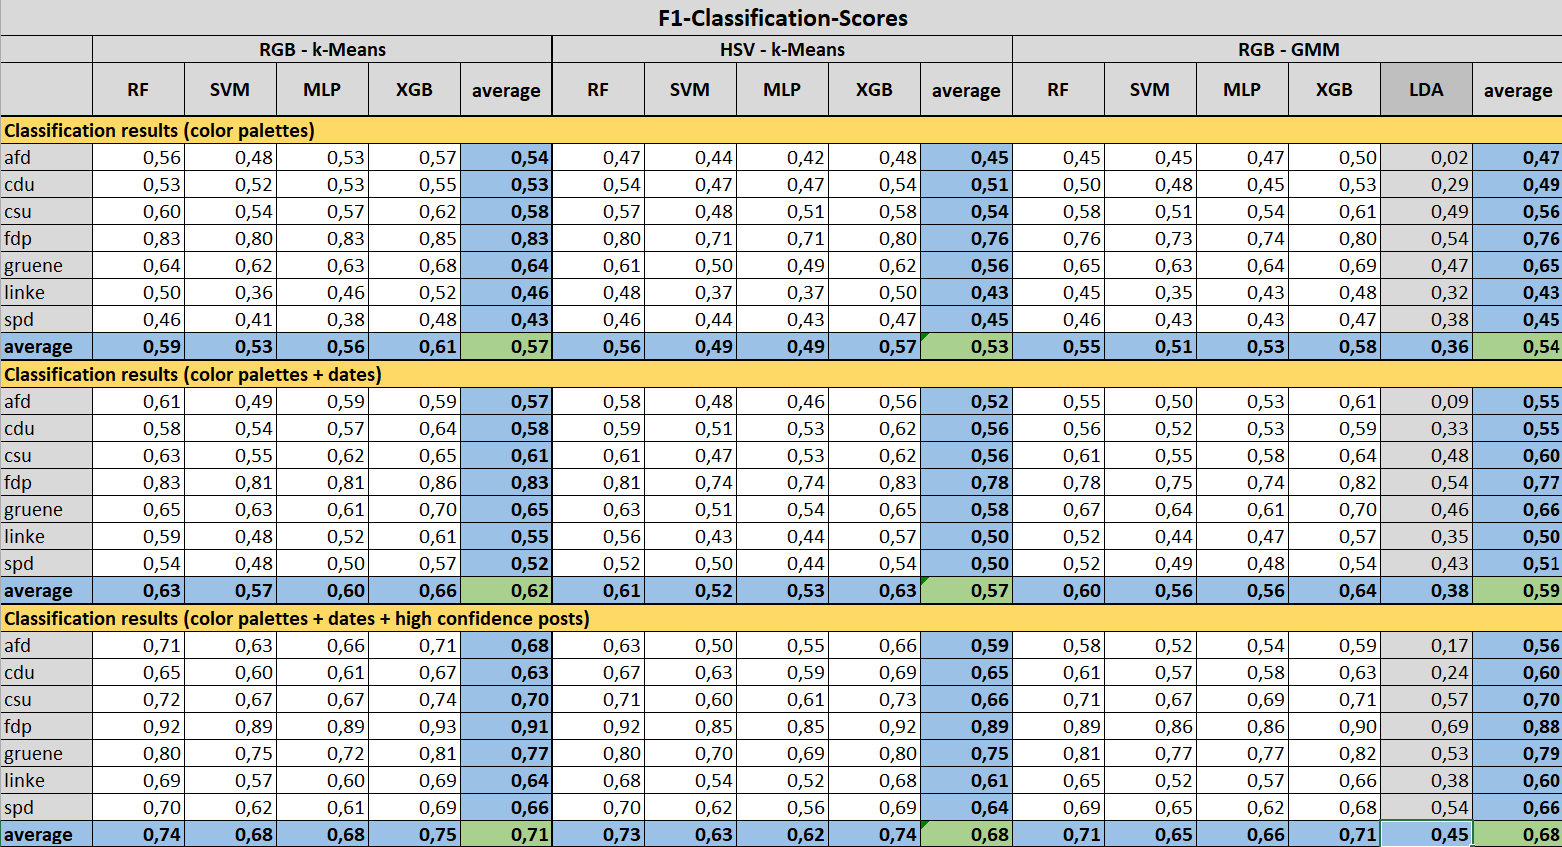

The training processes, including data preparation, model fitting, and evaluation, are documented in the notebooks [`classification_setup1.ipynb`](https://colab.research.google.com/github/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/f844059ac029ad1ad1d9f53fd755647ed5a29dd5/projects/05-1PLXXXX_political_color_posts/notebooks/classification_setup1.ipynb), [`classification_setup2.ipynb`](https://colab.research.google.com/github/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/f844059ac029ad1ad1d9f53fd755647ed5a29dd5/projects/05-1PLXXXX_political_color_posts/notebooks/classification_setup2.ipynb), and [`classification_setup3.ipynb`](https://colab.research.google.com/github/IvaroEkel/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/f844059ac029ad1ad1d9f53fd755647ed5a29dd5/projects/05-1PLXXXX_political_color_posts/notebooks/classification_setup3.ipynb). These notebooks also contain more detailed insights into model behavior beyond just the F1-scores.

## 6. Results

The classification results based on F1 scores reveal clear patterns across different feature setups, classifiers, and color spaces. Among the five classifiers tested, XGBoost consistently achieved the highest performance in all scenarios, closely followed by Random Forest. SVM generally performed worse, while MLP achieved mid-range results, occasionally performing on par with SVM in the most refined setup. LDA, however, performed by far the worst across all setups, indicating its limited effectiveness in handling the complex feature distributions of this classification task.

Comparing the three setups, it becomes evident that the inclusion of additional features leads to substantial improvements in classification performance. Using only color palette features (Setup 1) yielded an average F1 score of 0.53 across all classifiers. Adding the publication dates of posts (Setup 2) raised the average to 0.57, and incorporating only high-confidence posts (Setup 3) further increased the score to 0.66.

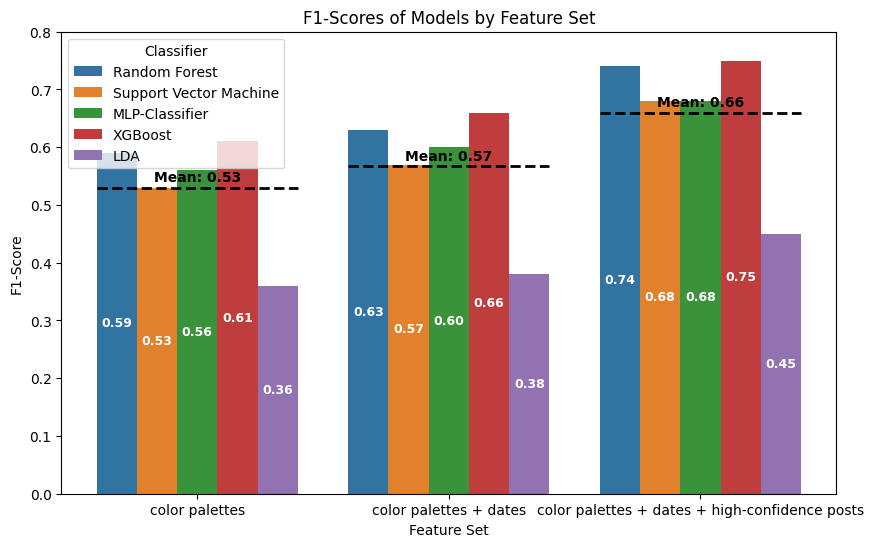

Regarding color spaces, the RGB representation consistently outperformed HSV across all three setups. While the differences were not dramatic, they were systematic. For instance, in Setup 3, the RGB-based models achieved an average F1 score of 0.71, compared to 0.68 in HSV. This indicates that RGB may better preserve relevant visual features in the context of this classification task.


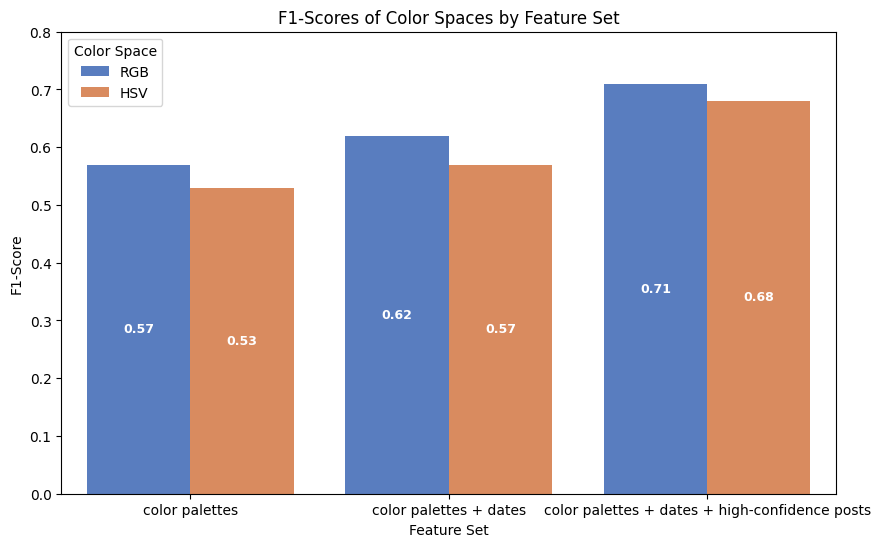

Across all three setups, K-Means consistently outperformed GMM. F1 scores were slightly higher for K-Means in each case: 0.57 vs. 0.54 in Setup 1, 0.62 vs. 0.59 in Setup 2, and 0.71 vs. 0.68 in Setup 3. This suggests that K-Means was slightly better suited for clustering the color data in this task.

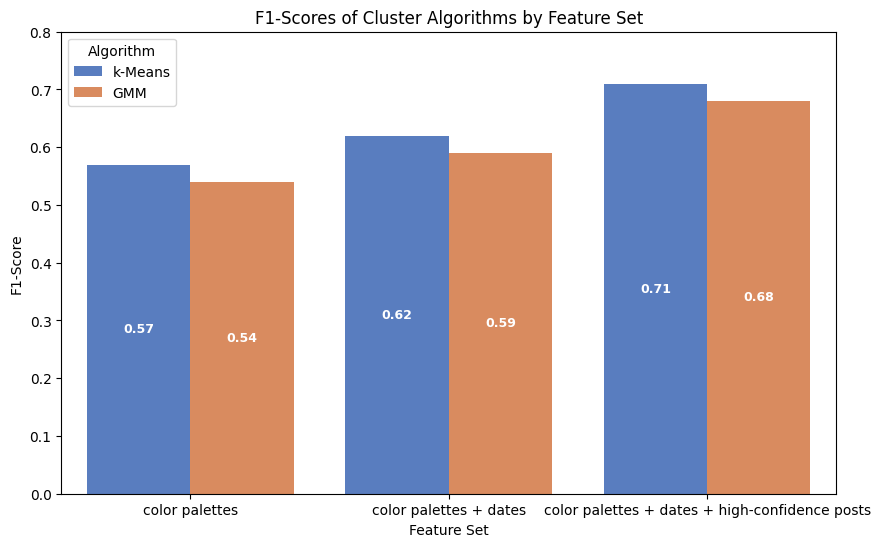

Analyzing party-specific performance further supports these findings. In Setup 3 with RGB features, some parties, particularly the FDP with an F1 score of 0.93, the CSU with 0.74, and the Greens with 0.81, achieved notably high values. These results suggest that their visual branding is especially consistent or distinctive. In contrast, parties like the CDU with 0.67 and the Left with 0.69 performed less strongly, although they still showed major improvements over the previous setups. The AfD performed quite well in most configurations, with competitive F1 scores similar to the mid-performing parties. However, its performance dropped sharply when using the combination of GMM clustering and LDA classification. This suggests that while the AfD’s visual features are generally classifiable, the soft clustering of GMM and the linear boundaries of LDA were poorly suited to capture its patterns.

## 7. Discussion

The results show that dominant color features offer some predictive value for identifying party affiliation on Instagram, but their effectiveness varies by party. Classification worked better for parties with consistent and saturated color schemes, while those with more varied or minimalist designs were harder to identify based on color alone. This suggests that party-related color usage depends on specific communication strategies or campaign phases.

Several limitations should be noted. First, party design is not static and can shift over time, especially during elections or rebranding. Although post dates were included as features, this may not fully capture such visual changes. Second, many posts lack clear or prominent use of party colors, leading to potential misclassification. Relying on only four dominant colors per image may also overlook important details in complex visuals. Finally, the models used were relatively simple and not optimized for this task, leaving room for improvement through better feature extraction and more advanced model tuning.

The comparison between RGB and HSV color spaces showed a clear advantage for RGB across all setups. One possible explanation is that RGB directly reflects the raw pixel values as captured in the images, preserving more fine-grained variations that are relevant for classification. In contrast, HSV separates hue, saturation, and value into distinct components, which can be beneficial for tasks focused on perceptual uniformity but may lead to a loss of subtle visual cues important for distinguishing party-specific design choices. Since the dominant colors in political visuals are often tied to branding elements like logos or overlays that appear in consistent RGB ranges, this color space may simply offer a closer representation of the features the model needs to learn.

Regarding clustering performance, K-Means consistently outperformed GMM across all setups. A likely reason is that K-Means produces hard cluster assignments and is computationally efficient, which may align better with the high-level goal of extracting a few dominant, well-separated colors per image. GMM, by contrast, allows soft assignments and assumes elliptical cluster shapes, which can be advantageous in more complex distributions but may add noise or ambiguity when the goal is to simplify image color content. Moreover, the relatively small number of clusters (four) and the strong dominance of one or two colors in many images may have favored the simpler clustering strategy of K-Means.

Finally, the notably poor performance of LDA compared to the other classifiers warrants attention. While most classifiers showed similar trends with varying degrees of accuracy, LDA underperformed substantially. This likely stems from its strong assumptions: LDA models each class as a Gaussian distribution with shared covariance, which may not hold in this dataset. The clustered color data is likely non-Gaussian and unevenly distributed across parties. Furthermore, LDA is a linear classifier, meaning it struggles to separate classes that are not linearly separable in the feature space. In contrast, classifiers like XGBoost or Random Forest can model nonlinear boundaries and interactions more effectively, which may explain their superior performance. The results suggest that LDA is not well suited for tasks involving complex, multimodal, or noisy visual feature spaces such as those derived from image clustering.

Future improvements could include using more color clusters or switching to perceptually uniform color spaces like CIELAB or CIECAM02, which better reflect how humans perceive color differences. Adding visual features beyond color, such as shapes, logos, or text—could also improve classification. On the modeling side, more advanced architectures like convolutional neural networks may capture richer visual patterns. Finally, temporal dynamics could be modeled more precisely using time-series methods or by incorporating metadata such as election timing, campaign phases, or political events.

## 8. Conclusion

This project set out to explore whether the dominant colors of Instagram posts by German political parties could be used to predict party affiliation using machine learning methods, including both probabilistic and non-probabilistic approaches. The research aimed to examine the extent to which visual features, particularly color, reflect political identity. It also investigated how different preprocessing and representation strategies influence classification performance, and how probabilistic models compare to their non-probabilistic counterparts.

The results show that while certain parties, such as the Greens and the SPD, tend to favor specific color palettes, these patterns are not consistent or distinctive enough across all posts to support highly accurate classification based on color alone. However, performance improved noticeably in the most refined configurations, especially in Setup 3 using the RGB color space and K-Means clustering. In this setting, some parties achieved relatively high F1 scores, suggesting that color can carry a useful political signal when combined with appropriate preprocessing choices.

Different feature representations and preprocessing strategies had measurable effects, although they did not overcome the fundamental limitations of relying solely on dominant color. The RGB color space consistently performed better than HSV, and K-Means clustering led to better results than the more flexible Gaussian Mixture Model. These findings indicate that simpler methods may be more effective in capturing relevant structure in the data when the task is narrowly focused on dominant color.

In terms of classification models, XGBoost achieved the highest performance, followed closely by Random Forest. Other classifiers such as SVM and MLP showed similar but slightly lower results. Linear Discriminant Analysis, which was only applied to features clustered using GMM, performed significantly worse than all other models across all setups and parties. This poor performance likely reflects a mismatch between LDA’s underlying assumptions and the complex, non-linear structure of the clustered color feature space.

In conclusion, while dominant color features provide some indication of political identity, they are not sufficient for reliable classification on their own. The results suggest that successful classification depends heavily on preprocessing decisions and model choice. Probabilistic approaches such as GMM and LDA did not show advantages in this context and were in some cases clearly inferior. Future research should expand the feature set to include additional visual characteristics or contextual data in order to better capture the complexity of political communication on social media.



## 9. References

<a name="ref-breiman2001"></a>
[1] Breiman, L. (2001). Random forests. *Machine Learning, 45*(1), 5–32.

<a name="ref-cortes1995"></a>
[2] Cortes, C., & Vapnik, V. (1995). Support-vector networks. *Machine Learning, 20*(3), 273–297.

<a name="ref-goodfellow2016"></a>
[3] Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep learning*. MIT Press.

<a name="ref-hsu2016"></a>
[4] Hsu, C.-W., Chang, C.-C., & Lin, C.-J. (2016). *A practical guide to support vector classification*. National Taiwan University.

<a name="ref-rodriguez2012"></a>
[5] Rodríguez-Galiano, V. F., Ghimire, B., Rogan, J., Chica-Olmo, M., & Rigol-Sanchez, J. P. (2012). An assessment of the effectiveness of a random forest classifier for land-cover classification. *ISPRS Journal of Photogrammetry and Remote Sensing, 67*, 93–104.

<a name="ref-rumelhart1986"></a>
[6] Rumelhart, D. E., Hinton, G. E., & Williams, R. J. (1986). Learning representations by back-propagating errors. *Nature, 323*(6088), 533–536.

<a name="ref-chen2016"></a>
[7] Chen, T., & Guestrin, C. (2016). XGBoost: A scalable tree boosting system. Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 785–794.

<a name="ref-macqueen1967"></a>
[8] MacQueen, J. (1967). Some Methods for Classification and Analysis of Multivariate Observations. In Proceedings of the Fifth Berkeley Symposium on Mathematical Statistics and Probability, Volume 1: Statistics (pp. 281–297). University of California Press.

<a name="ref-dempster1977"></a>
[9] Dempster, A. P., Laird, N. M., & Rubin, D. B. (1977). Maximum Likelihood from Incomplete Data via the EM Algorithm. Journal of the Royal Statistical Society: Series B (Methodological), 39(1), 1–22.

<a name="ref-fisher1936"></a>
[10] Fisher, R. A. (1936). The Use of Multiple Measurements in Taxonomic Problems. Annals of Eugenics, 7(2), 179–188.